# Project Introduction
This project explores the data from UCI Machine Learning posted up on Kaggle. 

In [53]:
# Imports 
%matplotlib inline

# General Python libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time

# Feature Extraction & Unsupervised Libraries
from sklearn.feature_extraction.text import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM # deprecated

from matplotlib.colors import LogNorm

# Learning/Model Libraries
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# Add trees libraries

# Evaluation Libarires
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# by JT
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn import preprocessing
import random

## Importing Raw Data

In [54]:
# Load data from csv files into pandas dataframes
RAWDATA_PATH = '../data/raw/UCIHumanActivity/'
df_rtrain = pd.read_csv(f'{RAWDATA_PATH}train.csv')
df_rtest = pd.read_csv(f'{RAWDATA_PATH}test.csv')

## Basic characteristics of the raw training data

In [55]:
print("There are %d rows and %d columns in raw training data, with %d empty fields." 
      % (df_rtrain.shape[0], df_rtrain.shape[1], sum(df_rtrain.isnull().sum())))
print("\nDatatypes in raw training data, along with their counts, which do sum to the number of columns:")
print(df_rtrain.dtypes.value_counts())
print("\nColumn name and datatype for the last three columns in the raw training data:")
print(df_rtrain.dtypes[-3:])

There are 7352 rows and 563 columns in raw training data, with 0 empty fields.

Datatypes in raw training data, along with their counts, which do sum to the number of columns:
float64    561
int64        1
object       1
dtype: int64

Column name and datatype for the last three columns in the raw training data:
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
dtype: object


## Basic characteristics of the raw test data

In [56]:
print("There are %d rows and %d columns in raw test data, with %d empty fields." 
      % (df_rtest.shape[0], df_rtest.shape[1], sum(df_rtrain.isnull().sum())))
print("\nDatatypes in raw test data, along with their counts, which sum to the number of columns:")
print(df_rtest.dtypes.value_counts())
print("\nColumn name and datatype for the last three columns in the raw test data:")
print(df_rtest.dtypes[-3:])

There are 2947 rows and 563 columns in raw test data, with 0 empty fields.

Datatypes in raw test data, along with their counts, which sum to the number of columns:
float64    561
int64        1
object       1
dtype: int64

Column name and datatype for the last three columns in the raw test data:
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
dtype: object


## Assessing balance of subjects and activities in raw training and test data

In [57]:
print("There are %d subjects (participants) in the raw training data, identified by integers." 
      % (len(np.unique(df_rtrain['subject']))))
print("The number of examples per subject ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtrain['subject'].value_counts()), max(df_rtrain['subject'].value_counts()),
        max(df_rtrain['subject'].value_counts()) / min(df_rtrain['subject'].value_counts())))
print(df_rtrain['subject'].value_counts())
print("\nExamples in the raw training data are labeled with one of %d activities." 
      % (len(np.unique(df_rtrain['Activity']))))
print("The number of examples per activity ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtrain['Activity'].value_counts()), max(df_rtrain['Activity'].value_counts()),
        max(df_rtrain['Activity'].value_counts()) / min(df_rtrain['Activity'].value_counts())))
df_rtrain['Activity'].value_counts()

There are 21 subjects (participants) in the raw training data, identified by integers.
The number of examples per subject ranges from 281 to 409 (factor of 1.5) as follows:
25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: subject, dtype: int64

Examples in the raw training data are labeled with one of 6 activities.
The number of examples per activity ranges from 986 to 1407 (factor of 1.4) as follows:


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [58]:
print("There are %d subjects (participants) in the raw test data, identified by integers." 
      % (len(np.unique(df_rtest['subject']))))
print("The number of examples per subject ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtest['subject'].value_counts()), max(df_rtest['subject'].value_counts()),
        max(df_rtest['subject'].value_counts()) / min(df_rtest['subject'].value_counts())))
print(df_rtest['subject'].value_counts())
print("\nExamples in the raw test data are labeled with one of %d activities." 
      % (len(np.unique(df_rtest['Activity']))))
print("The number of examples per activity ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtest['Activity'].value_counts()), max(df_rtest['Activity'].value_counts()),
        max(df_rtest['Activity'].value_counts()) / min(df_rtest['Activity'].value_counts())))
df_rtest['Activity'].value_counts()

There are 9 subjects (participants) in the raw test data, identified by integers.
The number of examples per subject ranges from 288 to 381 (factor of 1.3) as follows:
24    381
18    364
20    354
13    327
12    320
4     317
2     302
10    294
9     288
Name: subject, dtype: int64

Examples in the raw test data are labeled with one of 6 activities.
The number of examples per activity ranges from 420 to 537 (factor of 1.3) as follows:


LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64

## Observations on basic characteristics of the raw training and test data
* There are 7352 examples in the training set, and 2947 examples in the test set.
* There are 563 columns in both data sets.
* Each example is labeled with one of 6 activities (Y) in the last column, represented as a text object.
* There are 21 subjects in the training set and 9 others in the test set, each identified by an integer.
* The datatype for all 561 other columns is float64.
* There are no NaN fields.
* Within each dataset, subjects and activities have balanced representation across examples.

## Evaluating skew in the raw training set
* According to the Kaggle website, the training/test split was based on randomly-selected subjects. We'll assume for now that this is true (appears so), such that skew in training set reflects skew in test set. 

The following histograms suggest that range of values for a given feature is not always from -1 to 1.
Skew appears to be generally positive.


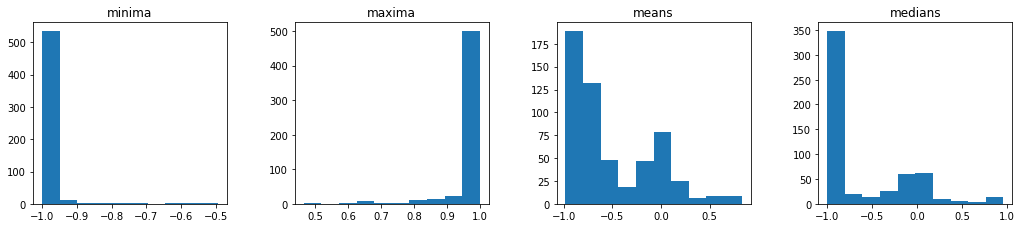

In [59]:
print("The following histograms suggest that range of values for a given feature is not always from -1 to 1.")
print("Skew appears to be generally positive.")
# https://blog.stata.com/2016/12/13/understanding-truncation-and-censoring/
exclude = ['Activity', 'subject']
mins = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].min()
mens = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].mean()
meds = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].median()
maxs = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].max()
df = pd.DataFrame({'minima':mins, 'means':mens, 'medians':meds, 'maxima':maxs})
headers = ['minima','maxima','means','medians']
plt.figure(num=None, figsize=(16,3))
for i in range(0,df.shape[1]):
    plt.subplot(1,4,i+1)
    plt.hist(df[headers[i]])
    plt.title(headers[i])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

A random sampling of features suggests there is also some censoring and/or truncation.
(In addition to the generally positive skew.)


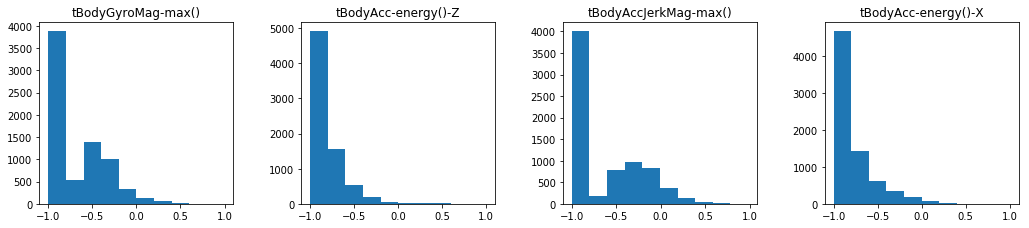

In [60]:
print("A random sampling of features suggests there is also some censoring and/or truncation.")
print("(In addition to the generally positive skew.)")
plt.figure(num=None, figsize=(16,3))
rand_list = random.sample(range(0,561),4)
for i in range(0,len(rand_list)):
    plt.subplot(1,4,i+1)
    plt.hist(df_rtrain[df_rtrain.columns[rand_list[i]]])
    plt.title(df_rtrain.columns[rand_list[i]])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

## Evaluating the potential for data compression
* 561 features (temporarily excluding the 'subject' column) is a lot to manage

Even with no feature scaling, only 5 PCA components are needed to explain 75% of total variance.
Scaling to a range from 0 to 1 does not affect portion of total variance explained.
In contrast, standardizing to zero mean and unity variance worsens compression.


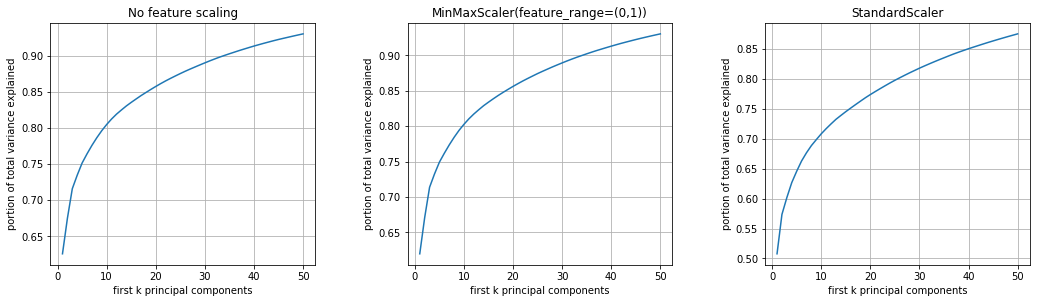

In [61]:
def first_k(k_range, pca):
    first_k = []
    for k in k_range:
        if k == 1:
            first_k.extend([pca.explained_variance_ratio_[k-1]])
        else:
            first_k.extend(first_k[k-2]+[pca.explained_variance_ratio_[k-1]])
    return first_k

exclude = ['Activity', 'subject']
k_range = list(range(1,51))

plt.figure(num=None, figsize=(16,4))

rtrain_ns = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)]
pca_ns = PCA(n_components=len(k_range))
pca_ns.fit(rtrain_ns)
plt.subplot(1,3,1)
plt.plot(k_range, first_k(k_range,pca_ns), label=df_rtrain['Activity'])
plt.title('No feature scaling')
plt.xlabel('first k principal components')
plt.ylabel('portion of total variance explained')
plt.grid(True)

rtrain_mms = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)]
mm_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
rtrain_mms = mm_scaler.fit_transform(rtrain_mms)
pca_mms = PCA(n_components=len(k_range))
pca_mms.fit(rtrain_mms)
plt.subplot(1,3,2)
plt.plot(k_range, first_k(k_range,pca_mms), label=df_rtrain['Activity'])
plt.title('MinMaxScaler(feature_range=(0,1))')
plt.xlabel('first k principal components')
plt.ylabel('portion of total variance explained')
plt.grid(True)

rtrain_sts = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)]
st_scaler = preprocessing.StandardScaler()
rtrain_sts = st_scaler.fit_transform(rtrain_sts)
pca_sts = PCA(n_components=len(k_range))
pca_sts.fit(rtrain_sts)
plt.subplot(1,3,3)
plt.plot(k_range, first_k(k_range,pca_sts), label=df_rtrain['Activity'])
plt.title('StandardScaler')
plt.xlabel('first k principal components')
plt.ylabel('portion of total variance explained')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
print("Even with no feature scaling, only 5 PCA components are needed to explain 75% of total variance.")
print("Scaling to a range from 0 to 1 does not affect portion of total variance explained.")
print("In contrast, standardizing to zero mean and unity variance worsens compression.")
plt.show()

Using MinMaxScaler and 2-component PCA, the examples are visibly split into two superclusters.
The first supercluster is comprised of stationary activities: laying, sitting, standing.
The second supercluster is comprised of dynamic activities: walking, walking downstairs, walking upstairs.
Whereas the stationary activities greatly overlap, dynamic activities are somewhat differentiated.
This suggests more than 2 PCA components may be needed to differentiate all activities.


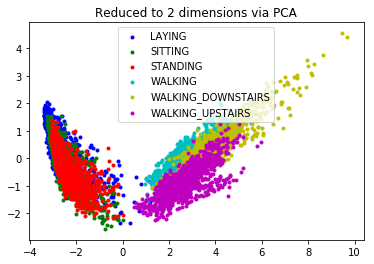

In [62]:
pca = PCA(n_components=2)
dim_reduc = pca.fit_transform(rtrain_mms) 
label_set = np.unique(df_rtrain['Activity'])
color_set = ['b', 'g', 'r', 'c', 'y', 'm']
plt.figure()
for i in range(0,len(label_set)):
    plt.scatter(dim_reduc[df_rtrain['Activity'] == label_set[i], 0], 
                dim_reduc[df_rtrain['Activity'] == label_set[i], 1], 
                color=color_set[i], marker='.', label=label_set[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Reduced to 2 dimensions via PCA')
print("Using MinMaxScaler and 2-component PCA, the examples are visibly split into two superclusters.")
print("The first supercluster is comprised of stationary activities: laying, sitting, standing.")
print("The second supercluster is comprised of dynamic activities: walking, walking downstairs, walking upstairs.")
print("Whereas the stationary activities greatly overlap, dynamic activities are somewhat differentiated.")
print("This suggests more than 2 PCA components may be needed to differentiate all activities.")
plt.show()

Plots for each subject show that differentiation between activities is cleaner for some subjects.
For example, walking downstairs and upstairs seem indistinguishable for subject 22.
In contrast, walking downstiairs and upstairs are fairly distinct for subject 11.


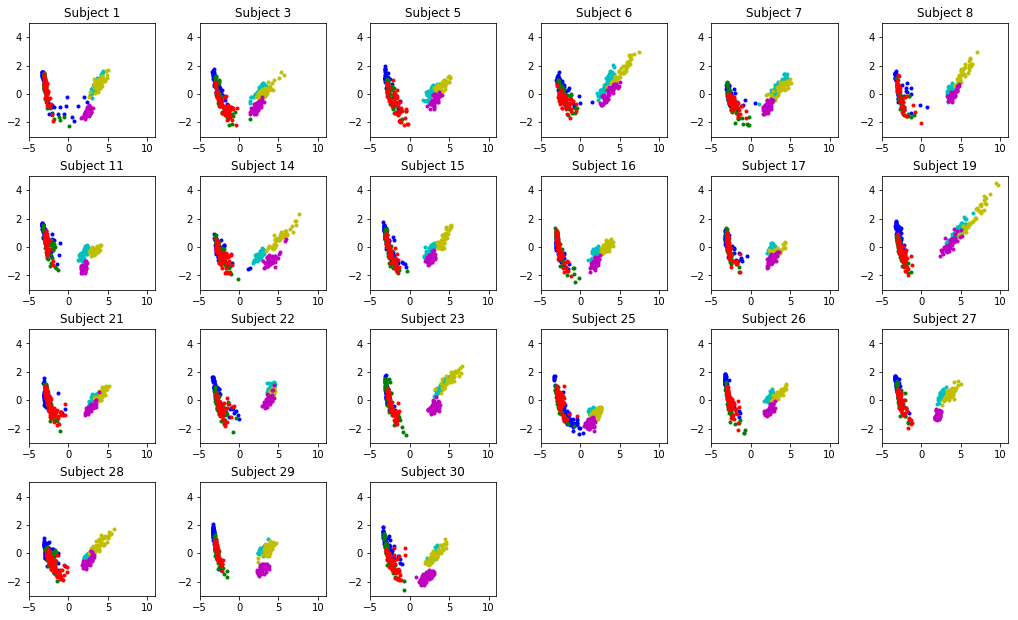

In [63]:
pca = PCA(n_components=2)
dim_reduc = pca.fit_transform(rtrain_mms) 
subject_set = np.unique(df_rtrain['subject'])
label_set = np.unique(df_rtrain['Activity'])
color_set = ['b', 'g', 'r', 'c', 'y', 'm']
plt.figure(num=None, figsize=(16,12))
for h in range(0,len(subject_set)):
    plt.subplot(5,6,h+1)
    for i in range(0,len(label_set)):
        plt.scatter(dim_reduc[(df_rtrain['Activity'] == label_set[i]) & (df_rtrain['subject'] == subject_set[h]), 0], 
                    dim_reduc[(df_rtrain['Activity'] == label_set[i]) & (df_rtrain['subject'] == subject_set[h]), 1], 
                    color=color_set[i], marker='.', label=label_set[i])
    #plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('Subject %d' % subject_set[h])
    plt.axis([-5,11,-3,5])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
print("Plots for each subject show that differentiation between activities is cleaner for some subjects.")
print("For example, walking downstairs and upstairs seem indistinguishable for subject 22.")
print("In contrast, walking downstiairs and upstairs are fairly distinct for subject 11.")
plt.show()

## Repartitioning (still by subject) to generate a dev set
* Subjects were already cleanly separated in the raw training and test sets (e.g., subject 1 is in train not test).
* Subjects will remain cleanly separated in this first train/dev/test split. 

In [69]:
df_rcomb = pd.concat([df_rtrain, df_rtest]).sample(frac=1).reset_index(drop=True)

# Tried mapping categorical subject feature to binary features
# Realized this would be better for logistic regression...
# unsubs = np.unique(df_rcomb['subject'])
# d = dict((unsub, np.array(df_rcomb['subject'] == unsub).astype(int)) for unsub in unsubs)
# df = pd.DataFrame(data=d)
# df_rcomb = df_rcomb.join(df)
# diffs = []
# for unsub in unsubs:
#     diffs.extend([df_rcomb[unsub]*unsub == df_rcomb['subject']])
# print(sum(np.array(diffs).flat))
# print(df_rcomb.shape)

sub_tdsplit = 18
sub_dtsplit = 24
shuffled = np.random.permutation(unsubs)
train_subs = shuffled[:sub_tdsplit]
dev_subs = shuffled[sub_tdsplit:sub_dtsplit]
test_subs = shuffled[sub_dtsplit:]
print("Subjects included in train set:", train_subs)
print("Subjects included in dev set:", dev_subs)
print("Subjects included in test set:", test_subs)

exclude = ['Activity', 'subject']
df_ptrain = df_rcomb.loc[df_rcomb['subject'].isin(train_subs)]
df_ptrainf = df_ptrain.loc[:, df_ptrain.columns.difference(exclude)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df_ptrainf = scaler.fit_transform(df_ptrainf)
df_pdev = df_rcomb.loc[df_rcomb['subject'].isin(dev_subs)]
df_pdevf = df_pdev.loc[:, df_pdev.columns.difference(exclude)]
df_pdevf = scaler.transform(df_pdevf)
df_ptest = df_rcomb.loc[df_rcomb['subject'].isin(test_subs)]
df_ptestf = df_ptest.loc[:, df_ptest.columns.difference(exclude)]
df_ptestf = scaler.transform(df_ptestf)
print("Train set shape:", df_ptrain.shape)
print("Dev set shape:", df_pdev.shape)
print("Test set shape:", df_ptest.shape)

Subjects included in train set: [ 3 16 11 27 25  5 26  1  7 23 15 19 29  6 22 28  8 21]
Subjects included in dev set: [12 10 20 13 14  9]
Subjects included in test set: [18  4 17  2 30 24]
Train set shape: (6278, 563)
Dev set shape: (1906, 563)
Test set shape: (2115, 563)


## Evaluating accuracy of 6-component GMMs with multicomponent PCA
* Also varying covariance type GMM hyperparameter. 

Accuracy varies somewhat between runs due to random initilization.
Reasonably close agreement in accuracy against dev and test suggests overfitting isn't excessive.


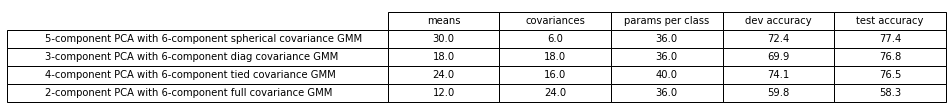

In [76]:
def experiment(pca_comp, gmm_comp, cov_type):
    pca = PCA(n_components=pca_comp)
    pca.fit(df_ptrainf) 
    dim_reduc = pca.transform(df_ptrainf) 
    gmm = []
    lp_dev = []
    lp_test = []
    label_set = np.unique(df_ptrain['Activity'])
    for i in range(0,len(label_set)):
        one_label = dim_reduc[df_ptrain['Activity'] == label_set[i]]
        gmm.extend([GaussianMixture(n_components=gmm_comp, covariance_type=cov_type)])
        gmm[i].fit(one_label)
        lp_dev.extend([gmm[i].score_samples(pca.transform(df_pdevf))]) # weighted log probabilities
        lp_test.extend([gmm[i].score_samples(pca.transform(df_ptestf))]) 
    pred_dev = []
    pred_test = []
    for j in range(0,lp_dev[0].shape[0]):
        col = [row[j] for row in lp_dev]
        pred_dev.extend([label_set[np.argmax(col)]])
    for j in range(0,lp_test[0].shape[0]):
        col = [row[j] for row in lp_test]
        pred_test.extend([label_set[np.argmax(col)]]) 
    means = gmm[0].means_.size
    covs = gmm[0].covariances_.size
    ppc = means + covs # parameters per class
    dev_acc = round(metrics.accuracy_score(df_pdev['Activity'],pred_dev)*100,1)
    test_acc = round(metrics.accuracy_score(df_ptest['Activity'],pred_test)*100,1)
    tab_cells.append([means, covs, ppc, dev_acc, test_acc])
    tab_rows.extend(["%d-component PCA with %d-component %s covariance GMM" 
                     % (pca_comp, gmm_comp, cov_type)])

tab_cols = ['means', 'covariances', 'params per class', 'dev accuracy', 'test accuracy']
tab_rows = []
tab_cells = []
ppc_lim = 50 # arbitrary limit on parameters per class
covs = ['spherical', 'diag', 'tied', 'full'] 

gmm_comp = np.unique(df_ptrain['Activity']).shape[0] # setting to class count for simplicity
for cov in covs:
    if cov == 'spherical':
        # each component has its own single variance
        pca_comp = 5
    elif cov == 'diag':
        # each component has its own diagonal covariance matrix
        pca_comp = 3
    elif cov == 'tied':
        # all components share the same general covariance matrix
        pca_comp = 4
    elif cov == 'full':
        # each component has its own general covariance matrix
        pca_comp = 2
    else:
        print("error: bad cov")
    if gmm_comp > 0:
        experiment(pca_comp, gmm_comp, cov)
            
tab_cells = np.array(tab_cells)
print("Accuracy varies somewhat between runs due to random initilization.")
print("Reasonably close agreement in accuracy against dev and test suggests overfitting isn't excessive.")

plt.figure(figsize=(10, 1)) 
tab = plt.table(cellText=tab_cells,rowLabels=tab_rows, colLabels=tab_cols, 
                cellLoc='center', loc='upper left')
for key, cell in tab.get_celld().items():
    row, col = key
plt.axis('off')
tab.scale(xscale=1, yscale=1.5) # for row spacing relative to text
plt.show()